# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 5. DDPG Training

In [5]:
import numpy as np
import torch
from collections import deque
from time import perf_counter

from agent import Agent

agent = Agent(state_size, action_size, 17)

def ddpg(n_episodes=6000, max_t=3000):
    scores_deque = deque(maxlen=100)
    scores_all = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agent.reset()
        start = perf_counter()
        for _ in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        max_score = np.max(scores)
        scores_deque.append(max_score)
        scores_all.append(max_score)
        print('\rEpisode {} ({:.1f}s)\tEP Max Score: {:.2f}\t100 EP Average: {:.2f}'.format(
            i_episode, perf_counter() - start, max_score, np.mean(scores_deque)), end="")
        if i_episode >= 100 and np.mean(scores_deque) >= 0.6:
            torch.save(agent.actor_local.state_dict(), 'actor.pth')
            torch.save(agent.critic_local.state_dict(), 'critic.pth')
            print('\nSuccess!')
            break
    return scores_all

start = perf_counter()
scores = ddpg()
print('{:.1f}s passed.'.format(perf_counter() - start))

Episode 1240 (12.2s)	EP Max Score: 2.50	100 EP Average: 0.60
Success!
675.4s passed.


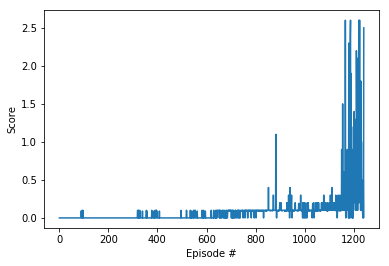

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Watch Smart Agents Play!

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

num_agents = 2
action_size = 2
state_size = 24

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
from agent import Agent

agent = Agent(state_size, action_size, 17)
agent.load_actor("actor.pth")

for i in range(10):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    agent.reset()
    while True:
        actions = agent.act(states, add_noise=False)
        env_info = env.step(actions)[brain_name]
        rewards = env_info.rewards
        dones = env_info.local_done
        states = env_info.vector_observations
        scores += rewards
        if np.any(dones):
            break
    max_score = np.max(scores)
    print('Episode {}\tEP Max Score: {:.2f}'.format(i, max_score))

C:\Users\mezho\AppData\Local\conda\conda\envs\drlnd\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 0	EP Max Score: 2.60
Episode 1	EP Max Score: 2.60
Episode 2	EP Max Score: 2.70
Episode 3	EP Max Score: 2.60
Episode 4	EP Max Score: 2.60
Episode 5	EP Max Score: 2.70
Episode 6	EP Max Score: 2.60
Episode 7	EP Max Score: 0.10
Episode 8	EP Max Score: 2.60
Episode 9	EP Max Score: 2.60
